<h1>
<center>Predicting Exchange Rate using Time Series</center>
</h1>

<h1>
<center>Avery Lee</center>
</h1>

# Predicting Exchange Rate using Time Series

Obtain daily values of the [Japan/U.S. Foreign Exchange Rate (DEXJPUS)](https://fred.stlouisfed.org/series/DEXJPUS) starting from Jan 1, 1990, to Jan 1, 2022, from FRED. 

In [ ]:
import pandas as pd
import numpy as np 
import pandas_datareader as pdr
from datetime import datetime
data = pdr.get_data_fred('DEXJPUS', datetime(1990,1,1),datetime(2022,1,1))
data = data.dropna()

Create a training set (before 2010), a validation set (Jan 2010 to Dec 2015), and a test set (the rest of the data). Turn the time series data into a supervised learning dataset where the features are the value of the exchange rate in the last 10 days inclusive of the current day, and the target is the value of the exchange rate in the next day.

In [ ]:
# make big supervised learning dataset 
def concat_rows_into_one(rows):
    rows_list = [rows.iloc[i] for i in range(len(rows))]
    return pd.concat(rows_list, ignore_index=True)

def ts_split(ts, feature_steps, target_steps):
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([concat_rows_into_one(ts[idx:idx+feature_steps]) for idx in range(n_obs)])
    y = np.array([ts.iloc[idx+feature_steps : idx+feature_steps+target_steps] for idx in range(n_obs)])
    return X, y

X, y = ts_split(data, feature_steps=10, target_steps=1) # lag 10, predict 1 step ahead value 

# split 
index_train_end = np.where(data.index=="2009-12-31")[0][0]+1
index_valid_start = np.where(data.index=="2010-1-4")[0][0]
index_valid_end = np.where(data.index=='2015-12-31')[0][0]+1
index_test_start = np.where(data.index=='2016-01-04')[0][0]

X_train = X[:index_train_end]
X_valid = X[index_valid_start:index_valid_end]
X_test = X[index_test_start:]

y_train = y[:index_train_end]
y_valid = y[index_valid_start:index_valid_end]
y_test = y[index_test_start:]

In [ ]:
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((5033, 10), (1504, 10), (1487, 10), (5033, 1, 1), (1504, 1, 1), (1487, 1, 1))

Fit a random forest regressor to predict the value of the exchange rate in the next day. Using the test set, report the mean squared error and the accuracy for the movement direction.

We can calculate the accuracy of the movement direction by determining what the actual movement direction is and comparing it to the movement direction corresponding to the predicted value of the exchange rate. 

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, y_train.ravel())
y_test_pred_rf = model_rf.predict(X_test)
movement_test_actual = X_test[:,-1] < y_test.ravel() # did exchange rate increase actually? 
movement_test_pred = X_test[:,-1] < y_test_pred_rf.ravel() # did exchange rate increase in prediction? 

# MSE and movement accuracy 
rf_mse = mean_squared_error(y_test[:,:,0], y_test_pred_rf)
rf_mov_acc = accuracy_score(movement_test_actual, movement_test_pred)

print(f'MSE: {rf_mse}, Movement Accuracy: {rf_mov_acc}')

MSE: 0.37566460849360955, Movement Accuracy: 0.5110961667787491


Now fit a deep RNN with 2 recurrent layers of 20 and 20 neurons, and an output layer which is 1 dense neuron. Use 100 epochs and the Nadam optimizer. 

Comparing this to the random forest above, this has higher MSE and slightly less movement accuracy (but not too big of a difference). The learning curve shows that the validation loss starts to increase around 30, but around 65 it quickly goes back down to similar values of the training error. 

In [ ]:
import tensorflow.keras as keras
import tensorflow as tf
import random as python_random
import matplotlib.pyplot as plt

def reset_session(seed=42):
    tf.random.set_seed(seed)
    python_random.seed(seed)
    np.random.seed(seed)
    tf.keras.backend.clear_session()

reset_session()

rnn_model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

rnn_model.compile(loss="mse", optimizer="nadam")

rnn_run = rnn_model.fit(X_train[..., np.newaxis], y_train, epochs=100,
                validation_data=(X_valid[..., np.newaxis], y_valid), verbose=0)

In [ ]:
# MSE
# rnn_mse = rnn_model.evaluate(X_valid, y_valid)
y_test_pred_rnn1 = rnn_model.predict(X_test)
rnn_mse = mean_squared_error(y_test[:,:,0], y_test_pred_rnn1)

# movement accuracy 
movement_test_actual = X_test[:,-1] < y_test.ravel() # did exchange rate increase actually? 
movement_test_pred = X_test[:,-1] < y_test_pred_rnn1.ravel() # did exchange rate increase in prediction? 

rnn_mse = mean_squared_error(y_test[:,:,0], y_test_pred_rnn1)
rnn_mov_acc = accuracy_score(movement_test_actual, movement_test_pred)

print(f'MSE: {rnn_mse}, Movement Accuracy: {rnn_mov_acc}')

MSE: 1.0793435103732263, Movement Accuracy: 0.5063887020847344


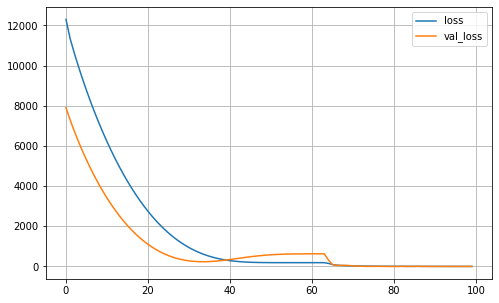

In [ ]:
rnn_df = pd.DataFrame(rnn_run.history)
rnn_df.plot(figsize=(8, 5))
plt.grid(True)
plt.show()

Create a supervised learning dataset suitable for predicting 3 days ahead instead of 1 day ahead. Adjust the deep RNN above so that it predicts 3 days ahead. Use 100 epochs and the Nadam optimizer. Using the test set, report the mean squared error and the accuracy for the movement direction for each of the 3 days ahead predictions. 

Comparing the results to the above model, there is generally higher MSE is this one. The movement accuracy is very slightly lower for the 1 day ahead, but is slightly higher for the 2 and 3 day aheads. The learning curve is very similar to the one above as well where the validation loss starts to increase around 30, but around 65 it quickly goes back down to similar values of the training error. 

In [ ]:
X_3ahead, y_3ahead = ts_split(data, feature_steps=10, target_steps=3) # lag 10, predict 3 step ahead value 

X_train_3ahead = X_3ahead[:index_train_end]
X_valid_3ahead = X_3ahead[index_valid_start:index_valid_end]
X_test_3ahead = X_3ahead[index_test_start:]

y_train_3ahead = y_3ahead[:index_train_end]
y_valid_3ahead = y_3ahead[index_valid_start:index_valid_end]
y_test_3ahead = y_3ahead[index_test_start:]

In [ ]:
X_train_3ahead.shape, X_valid_3ahead.shape, X_test_3ahead.shape, y_train_3ahead.shape, y_valid_3ahead.shape, y_test_3ahead.shape

((5033, 10), (1504, 10), (1485, 10), (5033, 3, 1), (1504, 3, 1), (1485, 3, 1))

In [ ]:
reset_session()

rnn_model_3ahead = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(3)
])

rnn_model_3ahead.compile(loss="mse", optimizer="nadam")

rnn_run_3ahead = rnn_model_3ahead.fit(X_train_3ahead[..., np.newaxis], y_train_3ahead, epochs=100,
                        validation_data=(X_valid_3ahead[..., np.newaxis], y_valid_3ahead), verbose=0)

In [ ]:
# predict 
y_test_pred_rnn = rnn_model_3ahead.predict(X_test_3ahead)

# MSE
rnn3_mse = mean_squared_error(y_test_3ahead[:,:,0], y_test_pred_rnn, multioutput='raw_values')

# movement accuracy 
def movement_acc(step_ahead):
    step_ahead -= 1
    movement_test_actual = X_test_3ahead[:,-1] < y_test_3ahead[:,step_ahead].ravel() # did exchange rate increase actually? 
    movement_test_pred = X_test_3ahead[:,-1] < y_test_pred_rnn[:,step_ahead].ravel() # did exchange rate increase in prediction? 
    movement_accuracy = accuracy_score(movement_test_actual, movement_test_pred)
    return movement_accuracy

# 1 day ahead 
move_acc1 = movement_acc(1)
# 2 days ahead 
move_acc2 = movement_acc(2)
# 3 days ahead 
move_acc3 = movement_acc(3)

print(f'MSE: {rnn3_mse}, \n Movement Accuracy (1, 2, 3 ahead): {move_acc1, move_acc2, move_acc3}')

MSE: [1.09320834 1.38987481 1.7815235 ], 
 Movement Accuracy (1, 2, 3 ahead): (0.5057239057239057, 0.5104377104377105, 0.5131313131313131)


In [ ]:
X_test_3ahead.shape

(1485, 10)

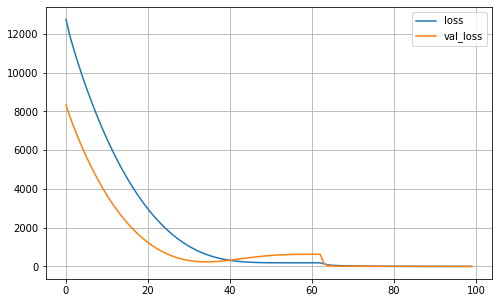

In [ ]:
rnn_df_3ahead = pd.DataFrame(rnn_run_3ahead.history)
rnn_df_3ahead.plot(figsize=(8, 5))
plt.grid(True)
plt.show()